# Анализ результатов A/B-тестирования: кумулятивные метрики

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.zip')
ab_data

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime

In [4]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [5]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

conv = n / N * 100%

* conv – конверсия в день t
* n – количество посетителей сайта, выполнивших целевое действие в день t
* N – общее количество посетителей сайта в день t

In [6]:
daily_data['conversion'] = daily_data.apply(lambda row: row['converted'] / row['users_count'] * 100, axis=1)
daily_data[daily_data['timestamp'] == pd.Timestamp('2017-01-05')]

,timestamp,group,users_count,converted,conversion
6,2017-01-05,A,6419,791,12.322792
7,2017-01-05,B,6509,743,11.414964


## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

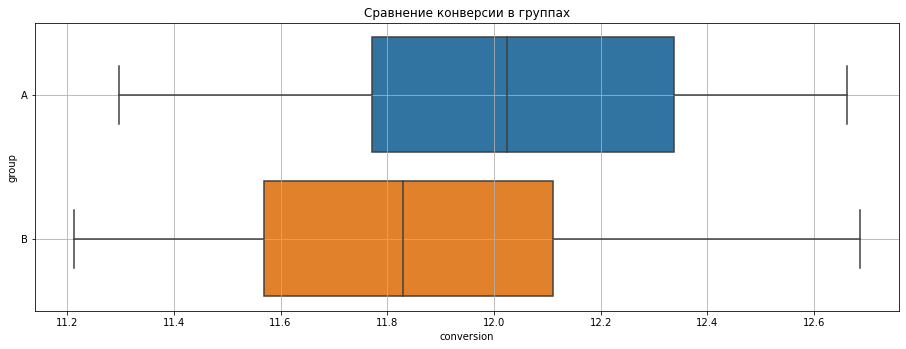

In [7]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(12, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid()

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [8]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

## КУМУЛЯТИВНЫЕ МЕТРИКИ

Для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии

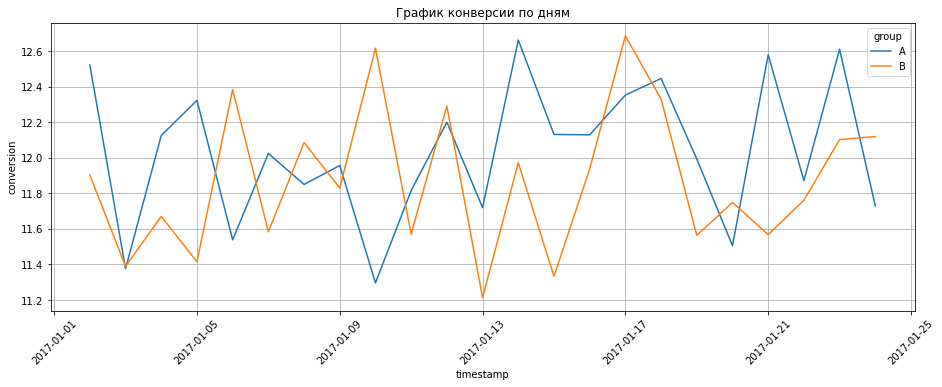

In [9]:
# создаём фигуру размером 12x4
fig = plt.figure(figsize=(12, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid()

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count.

In [10]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head()

/var/folders/7d/737wrt6574jfhqcjjxv10rnh0000gn/T/ipykernel_15329/3069716746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий

In [11]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе

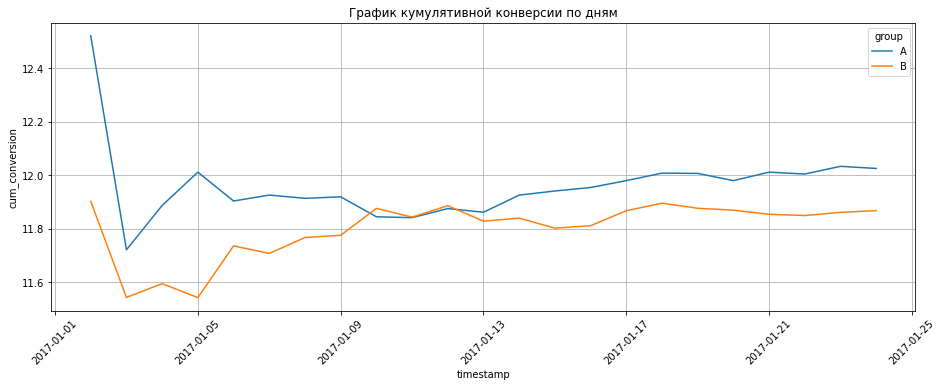

In [12]:
# создаём фигуру размером 12x4
fig = plt.figure(figsize=(12, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

### Задачи 4.6 – 4.9

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

Каждая таблица имеет следующие поля:

* date — дата наблюдения;
* cid — идентификатор посетителя;
* transactions — количество совершённых целевых действий (транзакций);
* revenue — сумма покупки;
* group — группа (тестовая — А, контрольная — B).

In [13]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')

#### 4.6
Постройте таблицу со следующими ежедневными показателями:

* количество посетителей сайта;
* суммарное число транзакций;
* общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [14]:
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

In [15]:
sample_a_cum = sample_a.groupby(by='date').agg({'cid':'count', 'transactions':'sum', 'revenue':'sum'})
sample_b_cum = sample_b.groupby(by='date').agg({'cid':'count', 'transactions':'sum', 'revenue':'sum'})


### 4.7 
Добавьте в каждую из таблиц кумулятивные метрики:

* кумулятивное количество посетителей сайта;
* кумулятивное суммарное число транзакций;
* кумулятивная общая сумма покупок (кумулятивная выручка).

In [16]:
sample_a_cum['cum_count_cid'] = sample_a.groupby(by='date')['cid'].count().cumsum()
sample_a_cum['cum_sum_transactions'] = sample_a.groupby(by='date')['transactions'].sum().cumsum()
sample_a_cum['cum_sum_revenue'] = sample_a.groupby(by='date')['revenue'].sum().cumsum()
sample_b_cum['cum_count_cid'] = sample_b.groupby(by='date')['cid'].count().cumsum()
sample_b_cum['cum_sum_transactions'] = sample_b.groupby(by='date')['transactions'].sum().cumsum()
sample_b_cum['cum_sum_revenue'] = sample_b.groupby(by='date')['revenue'].sum().cumsum()

sample_a_cum

,cid,transactions,revenue,cum_count_cid,cum_sum_transactions,cum_sum_revenue
date,,,,,,
2020-11-06,2576,16,1577279,2576,16,1577279
2020-11-07,2704,23,1721886,5280,39,3299165
2020-11-08,3354,25,846051,8634,64,4145216
2020-11-09,3234,18,708830,11868,82,4854046
2020-11-10,3022,29,826984,14890,111,5681030
2020-11-11,3218,19,1209656,18108,130,6890686
2020-11-12,3467,19,607839,21575,149,7498525
2020-11-13,3676,36,1338816,25251,185,8837341
2020-11-14,3372,30,2659277,28623,215,11496618


Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

In [17]:
# вычисляем кумулятивную конверсию действия покупки (в процентах)
sample_a_cum['cum_conversion'] = sample_a_cum['cum_sum_transactions']/sample_a_cum['cum_count_cid'] * 100
sample_b_cum['cum_conversion'] = sample_b_cum['cum_sum_transactions']/sample_b_cum['cum_count_cid'] * 100

# вычисляем кумулятивный средний чек
sample_a_cum['cum_average_check'] = sample_a_cum['cum_sum_revenue'] / sample_a_cum['cum_sum_transactions']
sample_b_cum['cum_average_check'] = sample_b_cum['cum_sum_revenue'] / sample_b_cum['cum_sum_transactions']

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [18]:
display(round(sample_a_cum['cum_conversion'].mean(), 2))
display(round(sample_b_cum['cum_conversion'].mean(), 2))

0.71

0.76

### 4.8 

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

In [19]:
sample_a_cum.head()

,cid,transactions,revenue,cum_count_cid,cum_sum_transactions,cum_sum_revenue,cum_conversion,cum_average_check
date,,,,,,,,
2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450


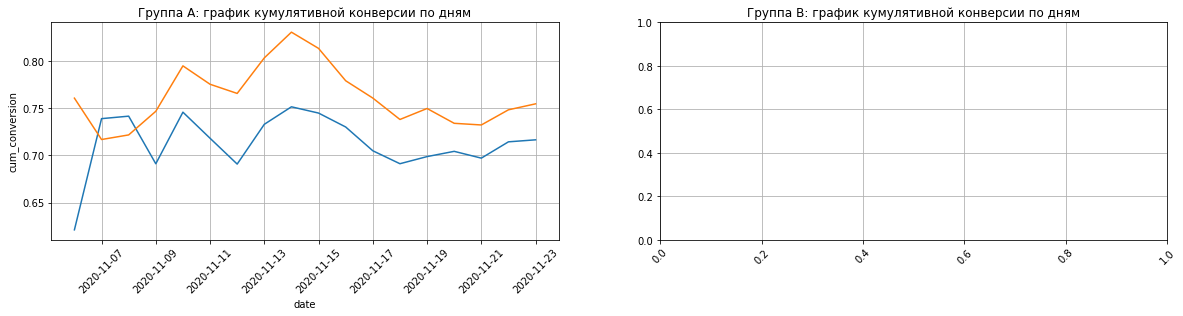

In [49]:
# создаём фигуру размером 12x4
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 4))

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=sample_a_cum, ax=ax1)
sns.lineplot(x='date', y='cum_conversion', data=sample_b_cum, ax=ax1)
# задаём подпись к графику
ax1.set_title('Группа А: график кумулятивной конверсии по дням')
ax2.set_title('Группа B: график кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax1.xaxis.set_tick_params(rotation = 45)
ax2.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax1.grid(True)
ax2.grid(True)

### 4.9
Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

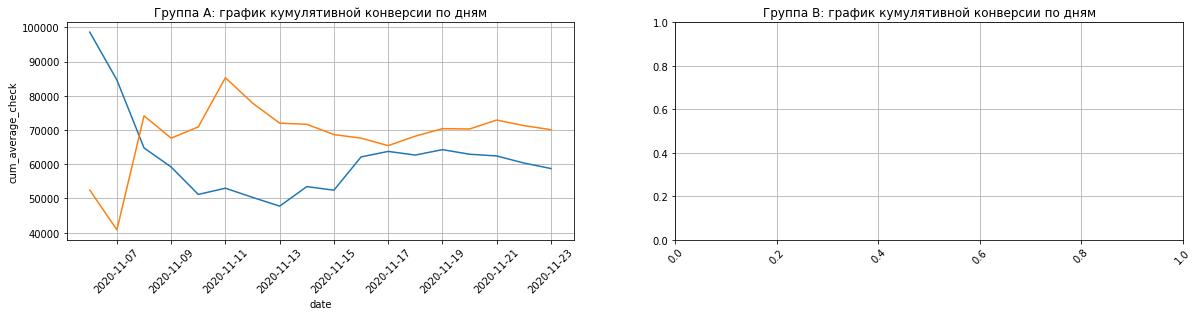

In [51]:
# создаём фигуру размером 12x4
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 4))

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_average_check', data=sample_a_cum, ax=ax1)
sns.lineplot(x='date', y='cum_average_check', data=sample_b_cum, ax=ax1)
# задаём подпись к графику
ax1.set_title('Группа А: график кумулятивной конверсии по дням')
ax2.set_title('Группа B: график кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax1.xaxis.set_tick_params(rotation = 45)
ax2.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax1.grid(True)
ax2.grid(True)

## СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

Оказывается, интересующий нас признак того, осуществлена конверсия пользователя или нет, — это случайная величина, имеющая распределение Бернулли. Такая случайная величина имеет два возможных исхода: 

* успех (1) — пользователь осуществил конверсию (совершил целевое действие); 
* неуспех (0) — пользователь не осуществил конверсию. 

Мы помним, что конверсия — это доля (пропорция) пользователей, которые добавили сопутствующий товар в корзину. То есть истинная конверсия — вероятность «успеха» (традиционно обозначают как ), или вероятность того, что пользователь совершит целевое действие.

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам z-критерием для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии.

Применим z-тест для пропорций на примере конверсии нашего интернет-магазина.

In [21]:
from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

* count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
* nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
* alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [22]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


Итак, будем проверять следующую новую гипотезу:

* H0 : Pa = Pb, то есть конверсии в группах А и B равны.

При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза).

* H1 : Pa > Pb, то есть конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости  и будем сравнивать полученное p-value с ним. По умолчанию функция proportions_ztest() возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [23]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. H0: {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Итак, мы получили <i>P - value= 0.1</i>. Оно больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 

## СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [24]:
time_data = pd.read_excel('data/time_data.xlsx')
time_data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


✏️ Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701)]

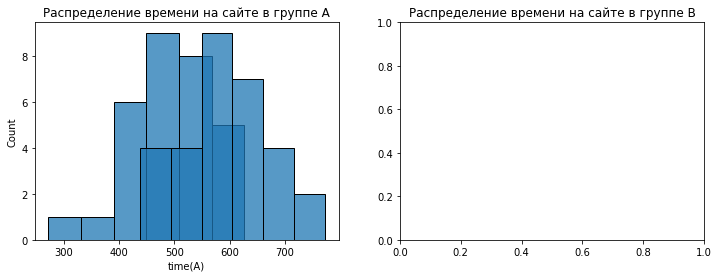

In [25]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[0], palette=sns.color_palette("husl", 1))
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');
sns.color_palette("husl", 1)

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats

In [26]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’)

In [27]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


### 5.2
Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите a = 0.1.

Каковы результаты тестирования?

In [28]:
a_ser = sample_a.agg({'cid':'count','transactions':'sum'})
b_ser = sample_b.agg({'cid':'count','transactions':'sum'})

sample_ab_piv = pd.DataFrame({'A':a_ser,'B':b_ser})
sample_ab_piv

,A,B
cid,61571,61383
transactions,441,463


In [29]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=sample_ab_piv.loc['transactions'], #число "успехов"
    nobs=sample_ab_piv.loc['cid'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. H0: {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


### 5.3 
Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите a=0.1.

Каковы результаты тестирования?

In [30]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(sample_a_cum['cum_average_check'])
shapiro_result_b = shapiro(sample_b_cum['cum_average_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


### 5.4 
Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите a=0.1.

Каковы результаты тестирования?

In [31]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группе A и в группе B статистически равны'
H1 = 'Ежедневный средний чек в группе A статистически меньше, чем в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для теста Манна-Уитни
_, p_value = mannwhitneyu(
    sample_a_cum['cum_average_check'], 
    sample_b_cum['cum_average_check'], 
    alternative='less',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. H0: {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.0
Отвергаем нулевую гипотезу. H0: Ежедневные средние чеки в группе A и в группе B статистически равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе A статистически меньше, чем в группе B


# ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ

## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.

Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.

Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

In [32]:
# Задаём необходимые для вычисления переменные:

n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение z-критического для любого уровня значимости можно при помощи функции norm.ppf() из модуля scipy.stats. По специфическим причинам реализации функция возвращает не совсем z-критическое, а его отрицательный модуль, поэтому мы берём его со знаком минус.

In [33]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

Итак, у нас есть все ингредиенты, чтобы «приготовить» доверительный интервал. Вычислим нижнюю и верхнюю границу по формуле. Округлим результат до целого и выведем на экран

In [34]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
 
# Доверительный интервал: (12180, 20020)

Доверительный интервал: (12180, 20020)


In [35]:
def calculate_confidence_interval(n, x_mean, sigma, gamma):
    """Функция для расчёта доверительного интервала для истинного среднего

    Args:
        n (int): размер выборки
        x_mean (float): выборочное среднее
        sigma (float): истинное стандартное отклонение
        gamma (float): уровень надёжности

    Returns:
        tuple: кортеж с округлёнными границами расчитанного интервала
    """
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    print('z_crit = ', z_crit)
    eps = round(z_crit, 2) * sigma/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return (round(lower_bound, 2), round(upper_bound, 2)) # возвращаем кортеж из округлённых границ интервала

calculate_confidence_interval(36, 16100, 12000, 0.95)

z_crit =  1.959963984540054


(12180.0, 20020.0)

Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

⚡ Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

### 6.5
Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [36]:
calculate_confidence_interval(64, 12.35, 2.4, 0.9)

z_crit =  1.6448536269514729


(11.86, 12.84)

## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

In [37]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [38]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

Теперь составим доверительный интервал для истинного среднего. Вычислим левую и нижнюю границу по формуле. Округлим результат и выведем на экран:

In [39]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
# Доверительный интервал: (1778, 2222)

Доверительный интервал: (1778, 2222)


Итак, мы на 95 % уверены, что истинные траты покупателей в нашем магазине лежат в интервале от 1 778 до 2 222 рублей. 

Примечание. Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

* Выборка должна быть случайной
* Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

### 6.6
Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540.  Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [40]:
n_task = 25 # размер выборки
k_task = n_task - 1 # число степеней свободы
x_mean_task = 3540 # выборочное среднее
x_std_task = 1150 # выборочное стандартное отклонение
gamma_task = 0.90 # уровень надёжности
alpha_task = 1 - gamma_task # уровень значимости

t_crit_task = -t.ppf(alpha_task/2, k_task) # t-критическое

eps_task = t_crit_task * x_std_task/(n_task ** 0.5) # погрешность
lower_bound_task = x_mean_task - eps_task # левая (нижняя) граница
upper_bound_task = x_mean_task + eps_task # правая (верхняя) граница
confidence_interval_task = (round(lower_bound_task), round(upper_bound_task)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval_task)) # выводим результат

Доверительный интервал: (3146, 3934)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

В контексте задачи A/B-тестирования нам бы хотелось знать истинную конверсию (а не ту, которая подсчитана по выборке) в контрольной и тестовой группе, а также оценить истинную разницу между конверсиями. 

Если подумать, то на самом деле мы решаем задачу оценки истинной пропорции генеральной совокупности по выборке. А значит,  нужно научиться строить доверительный интервал для пропорции.

In [41]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [42]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    """Вычисление доверительного интервала для пропорций

    Args:
        n (int): размер выборки
        x_p (float): выборочная пропорция
        gamma (float, optional): уровень надёжности. Defaults to 0.95

    Returns:
        float, float: кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой
    """
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [43]:
conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(), # размер выборки
    x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(), # размер выборки
    x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86 % до 12.19 %, а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.

✏️ Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [44]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """Вычисление границ доверительного интервала разницы конверсий

    Args:
        n (list): список из размеров выборки для групп А и B соответственно
        xp (list): список из выборочных пропорций для групп А и B соответственно
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        tupple: кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % 
        и округлённых до второго знака после запятой
    """
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

Вызовем функцию и построим интересующий нас доверительный интервал

In [45]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

In [46]:
diff_proportions_conf_interval([1000, 1000], [45/1000, 50/1000])

(-1.36, 2.36)